### Identificação de Erros de Cadastro de Potência

Analisem a relação entre a potência cadastrada de cada usina e sua
geração efetiva ao longo da sua existência. Utilizem análises
comparativas e algoritmos de detecção de anomalias para identificar
usinas cuja geração não corresponde ao valor de potência registrado.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
DATASETS_FOLDER = './datasets/'

In [4]:
df_geracao = pd.read_csv(DATASETS_FOLDER + 'geracao', chunksize=1000000)
df_usina = pd.read_csv(DATASETS_FOLDER + '/usina')

In [7]:
# Removendo os dados ausentes da coluna potencia
df_usina.dropna(subset=['potencia'], inplace=True)

# Removendo a coluna last_plant_history_id
df_usina.drop(columns=['last_plant_history_id'], inplace=True)

In [10]:
# Selecionando 100000 dados de amostra
df_usina_amostra = df_usina.sample(n=100000, random_state=42)

# IDs usinas
ids_usinas_amostra = df_usina_amostra['id'].tolist()

In [11]:
geracao_filtrada = []

for chunk in df_geracao:
    # Filtrar dados de geracao das usinas amostra
    chunk_filtrado = chunk[chunk['id_usina'].isin(ids_usinas_amostra)]

    # Adicionar o chunk filtrado à lista
    geracao_filtrada.append(chunk_filtrado)

# Concatenar todos os chunks filtrados em um único DataFrame
df_geracao_filtrada = pd.concat(geracao_filtrada, ignore_index=True)

In [ ]:
# Identificando valores NaN
df_geracao_filtrada.isna().sum()

id                  0
data                0
prognostico      2515
quantidade     113683
id_usina            0
dtype: int64

In [32]:
df_geracao_filtrada.dropna(subset=['quantidade', 'prognostico'], inplace=True)

Caso a usina esteja gerando muito acima do prognóstico (geração 20% maior que o prognóstico), ou muito baixo (geração menor que 70% do prognóstico) em um determinado período de tempo é possível que a usina esteja com algum problema ou que os dados de cadastro de potência da usina ou de prognóstico estejam incorretos

In [ ]:
# Calcular a média de geração e prognóstico por usina
media_geracao_prognostico = (
    df_geracao_filtrada.groupby('id_usina')[['quantidade', 'prognostico']]
    .mean()
    .reset_index()
    .rename(columns={
        'quantidade': 'media_geracao_diaria',
        'prognostico': 'media_prognostico_diaria'
    })
)

# Combinar dados
dados = pd.merge(df_usina, media_geracao_prognostico, left_on='id', right_on='id_usina')
dados['eficiencia'] = dados['media_geracao_diaria'] / dados['potencia']
dados['desempenho_vs_prognostico'] = dados['media_geracao_diaria'] / dados['media_prognostico_diaria']

# Identificar erros de cadastro
erros_cadastro = dados[dados['media_geracao_diaria'] > dados['potencia']]

# Identificar usinas com geração abaixo ou acima do esperado pelo prognóstico
usinas_abaixo_prognostico = dados[dados['desempenho_vs_prognostico'] < 0.7]
usinas_acima_prognostico = dados[dados['desempenho_vs_prognostico'] > 1.2]

# Identificar usinas para manutenção (geração real muito baixa ou eficiência baixa)
usinas_para_manutencao = dados[
    (dados['media_geracao_diaria'] <= 0.7) | 
    (dados['desempenho_vs_prognostico'] < 0.7)
]

# Visualizar resultados
print("Erros de Cadastro:")
print(erros_cadastro.shape)

print("\nUsinas Abaixo do Prognóstico:")
print(usinas_abaixo_prognostico.shape)

print("\nUsinas Acima do Prognóstico:")
print(usinas_acima_prognostico.shape)

print("\nUsinas para Manutenção:")
print(usinas_para_manutencao.shape)

Erros de Cadastro:
(85679, 8)

Usinas Abaixo do Prognóstico:
(24452, 8)

Usinas Acima do Prognóstico:
(19175, 8)

Usinas para Manutenção:
(25397, 8)


### Usinas com resultados corretos e esperados

In [34]:
# Usinas corretas
dados['eficiencia_esperada'] = (dados['eficiencia'] >= 0.7) & (dados['eficiencia'] <= 1.0)
dados['prognostico_esperado'] = (dados['desempenho_vs_prognostico'] >= 0.9) & (dados['desempenho_vs_prognostico'] <= 1.1)
dados['sem_erros'] = dados['media_geracao_diaria'] <= dados['potencia']

usinas_corretas = dados[
    dados['eficiencia_esperada'] &
    dados['prognostico_esperado'] &
    dados['sem_erros']
]

usinas_corretas.head()

,id,potencia,unidade_consumidora_id,id_usina,media_geracao_diaria,media_prognostico_diaria,eficiencia,desempenho_vs_prognostico,eficiencia_esperada,prognostico_esperado,sem_erros
28971,154181,17.12,173973,154181,16.879919,16.148661,0.985977,1.045283,True,True,True
31295,438089,15.00,502683,438089,13.824215,14.649193,0.921614,0.943684,True,True,True
73313,150664,29.70,169942,150664,26.704148,27.085673,0.899130,0.985914,True,True,True
84123,955408,10.08,1101594,955408,8.402737,8.991095,0.833605,0.934562,True,True,True
89219,289035,33.87,326066,289035,33.662414,33.799598,0.993871,0.995941,True,True,True


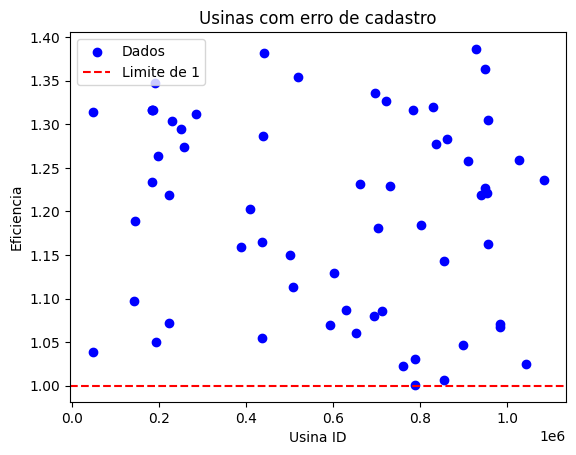

,id,potencia,unidade_consumidora_id,id_usina,media_geracao_diaria,eficiencia
1555,312800,3.00,354174,312800,0.0,0.0
94462,478000,9.90,548553,478000,0.0,0.0
28636,304527,27.10,344580,304527,0.0,0.0
89713,733668,33.00,825342,733668,0.0,0.0
76998,1019397,4.36,1176971,1019397,0.0,0.0


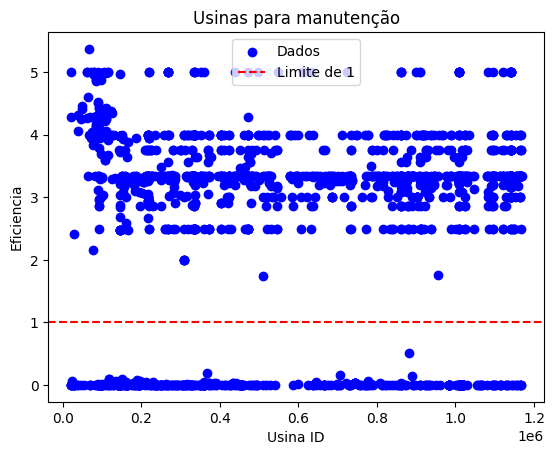

,id,potencia,unidade_consumidora_id,id_usina,media_geracao_diaria,eficiencia
12,315873,0.0,357597,315873,0.0,NaN
16,315706,0.0,357430,315706,0.0,NaN
34,725075,0.0,815325,725075,0.0,NaN
41,190435,0.0,214374,190435,0.0,NaN
56,754207,0.0,851278,754207,0.0,NaN


In [ ]:
# Agrupar geração por usina
media_geracao = (
    df_geracao_filtrada_p.groupby('id_usina')['quantidade']
    .mean()
    .reset_index()
    .rename(columns={'quantidade': 'media_geracao_diaria'})
)

# Combinar dados
dados = pd.merge(df_usina, media_geracao, left_on='id', right_on='id_usina')
dados['eficiencia'] = dados['media_geracao_diaria'] / dados['potencia']

erros_cadastro = dados[dados['media_geracao_diaria'] > dados['potencia']]

# Identificar usinas com eficiência abaixo do limiar
usinas_para_manutencao = dados[dados['media_geracao_diaria'] <= 0.7]
usinas_para_manutencao.head()

# Discrepancia
erros_cadastro = erros_cadastro[erros_cadastro['eficiencia'] < 1.4]

# Criar o gráfico de linhas para os dados de x e y
plt.scatter(erros_cadastro['id'], erros_cadastro['eficiencia'], label='Dados', color='b')

# Adicionar a linha horizontal em y = 1
plt.axhline(y=1, color='r', linestyle='--', label='Limite de 1')

# Adicionar título e rótulos aos eixos
plt.title('Usinas com erro de cadastro')
plt.xlabel('Usina ID')
plt.ylabel('Eficiencia')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

display(dados.sort_values('eficiencia').head())

# Criar o gráfico de linhas para os dados de x e y
plt.scatter(usinas_para_manutencao['id'], usinas_para_manutencao['eficiencia'], label='Dados', color='b')

# Adicionar a linha horizontal em y = 1
plt.axhline(y=1, color='r', linestyle='--', label='Limite de 1')

# Adicionar título e rótulos aos eixos
plt.title('Usinas para manutenção')
plt.xlabel('Usina ID')
plt.ylabel('Eficiencia')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

display(usinas_para_manutencao.head())